# Part I: Windows-based stereo 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
from matplotlib.colors import LogNorm

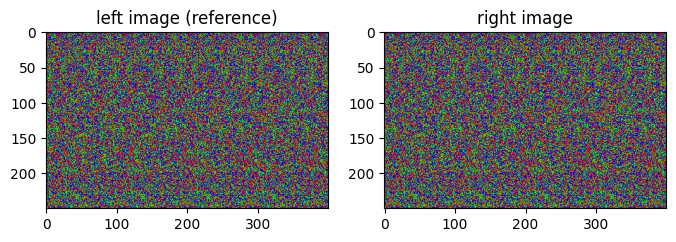

In [ ]:
im_left = image.imread("images/stereo_pairs/rds_left.gif")
im_right = image.imread("images/stereo_pairs/rds_right.gif")

fig = plt.figure(figsize = (8, 4))
plt.subplot(121)
plt.title("left image (reference)")
plt.imshow(im_left)
plt.subplot(122)
plt.title("right image")
plt.imshow(im_right)

# the range of disparities for this random dot stereo pair 
d_min = 0
d_max = 2

### We compute and visualize (as an image) an array of "squared differences" between RGB pixel values in the left and the right images. Treat each RGB pixel value as 3-vector and interprete "squared difference" as squared L2 norm of the difference between the corresponding vectors. 

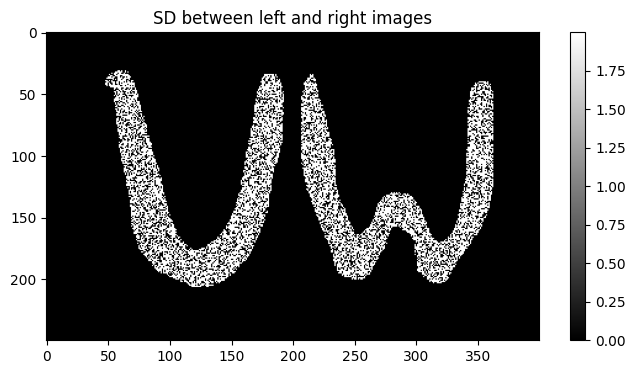

In [5]:
im_L_float = im_left.astype(np.float32) / 255.0
im_R_float = im_right.astype(np.float32) / 255.0

SD = np.linalg.norm(im_L_float - im_R_float, axis = -1)**2

fig = plt.figure(figsize = (8, 4))
plt.title("SD between left and right images")
plt.imshow(SD, cmap = "gray")
plt.colorbar()

We write a function for computing squared differences between RGB pixel values in the reference (left) image and the "shifted" right image for ALL shifts/disparities $\Delta$ in the range $\Delta\in [d_{min},d_{max}]$. The output is an array $SD$ such that $SD[i]$ is an image of Squared Differences for shift $\Delta = d_{min} + i$ for any $i\in [0,d_{max}-d_{min}]$. 

In [6]:

def SD_array(imageL, imageR, d_minimum, d_maximum):
    # initialization of the array of "squared differences" for different shifts
    SD = np.zeros((1+d_maximum-d_minimum,np.shape(imageL)[0],np.shape(imageL)[1]))

    # make sure rgb values are floats to avoid overflow
    im_L_float = imageL.astype(np.float32) 
    im_R_float = imageR.astype(np.float32) 

    for i, d in enumerate(range(d_minimum, d_maximum + 1)):
        im_R_float_roll = np.roll(im_R_float, d, axis=1)
        SD[i] = np.linalg.norm(im_L_float - im_R_float_roll, axis = -1)**2
    return SD

### We use $SD\_array$ function to compute SD images for the random dot stereo pair. Visualize such squared difference images for $\Delta=d_{min}$, $\Delta = d_{mid}\approx\frac{d_{min}+d_{max}}{2}$, and $\Delta=d_{max}$.

(250, 400, 4)
(250, 400, 4)
(3, 250, 400)


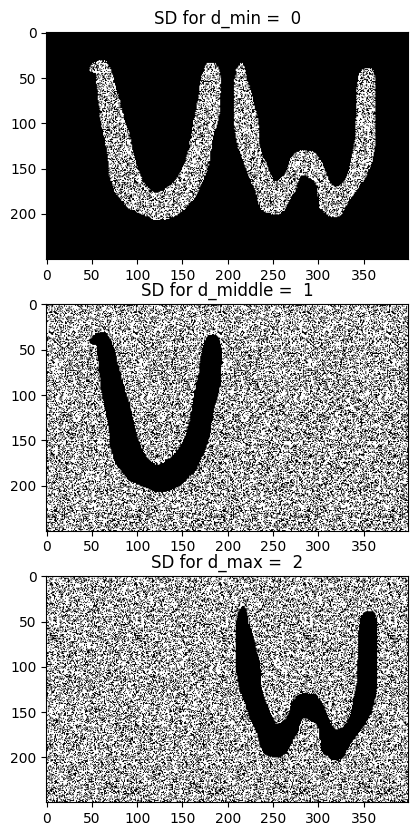

In [7]:
SD = SD_array(im_left, im_right, d_min, d_max)    
print(np.shape(im_left))
print(np.shape(im_right))
print(np.shape(SD))

fig = plt.figure(figsize = (5, 10))
plt.subplot(311)
plt.title('SD for d_min = {:>2d}'.format(d_min))
plt.imshow(SD[0], cmap = "gray")
plt.subplot(312) 
d_middle = round((d_min+d_max)/2)
plt.title('SD for d_middle = {:>2d}'.format(d_middle))
plt.imshow(SD[d_middle-d_min], cmap = "gray")
plt.subplot(313)
plt.title('SD for d_max = {:>2d}'.format(d_max))
plt.imshow(SD[d_max-d_min], cmap = "gray")
#plt.colorbar(cax=plt.axes([0.91, 0.25, 0.01, 0.5]))

Function to compute an "integral image" for any given "scalar" image

In [ ]:
# Function integral_image can be applied to any scalar 2D array/image. 
# This function returns a double/float64 (precision) array/image of the same size.

def integral_image(img):
    m, n  = img.shape
    img = np.array(img, dtype=float) 
    int_img = np.zeros(img.shape, dtype=float) 

    int_img = np.cumsum(img, axis=1)
    int_img = np.cumsum(int_img, axis=0)
    
    return int_img

### Apply $intergal\_image$ function to the "squared differences" (SD) for each disparity

(3, 250, 400) (3, 250, 400)


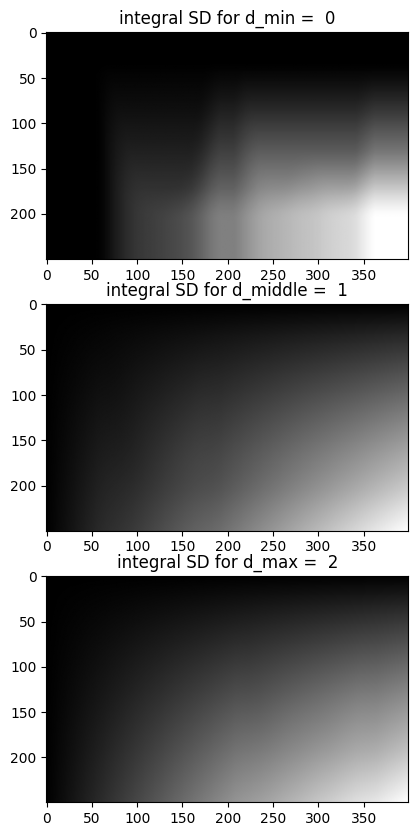

In [9]:
integral_SD = np.zeros(np.shape(SD))
print(np.shape(integral_SD),np.shape(SD))

for Delta in range(1+d_max-d_min):
    integral_SD[Delta] = integral_image(SD[Delta])
        
fig = plt.figure(figsize = (5, 10))
plt.subplot(311)
plt.title('integral SD for d_min = {:>2d}'.format(d_min))
plt.imshow(integral_SD[0], cmap = "gray")
plt.subplot(312) 
d_middle = round((d_min+d_max)/2)
plt.title('integral SD for d_middle = {:>2d}'.format(d_middle))
plt.imshow(integral_SD[d_middle-d_min], cmap = "gray")
plt.subplot(313)
plt.title('integral SD for d_max = {:>2d}'.format(d_max))
plt.imshow(integral_SD[d_max-d_min], cmap = "gray")
#plt.colorbar(cax=plt.axes([0.91, 0.2, 0.01, 0.6]))

### Function below sums the elements of the input image within fixed-size windows around image pixels.  <img src="images\windows.png">

In [ ]:
# function windSum can be applied to any scalar 2D array/image. It returns an array/image where the value of 
# each element (pixel p) is the "sum" of the values in the input array/image within a window around element p.
# The return image is the same size/type and have its margins (around half-window width) filled with INFTY.

INFTY = np.inf

def windSum(img, window_width):
    int_img = integral_image(img) 
    
    shift_left = int((window_width-1) / 2) + 1
    shift_up = shift_left
    shift_right = -(window_width - shift_left)
    shift_down = shift_right

    top_left = np.roll(np.roll(int_img, shift_left, axis=1), shift_up, axis=0)
    top_right = np.roll(np.roll(int_img, shift_right, axis=1), shift_up, axis=0)
    bottom_left = np.roll(np.roll(int_img, shift_left, axis=1), shift_down, axis=0)
    bottom_right = np.roll(np.roll(int_img, shift_right, axis=1), shift_down, axis=0)
    
    result = bottom_right - bottom_left - top_right + top_left
    
    result[:,:shift_left] = INFTY # first shiftLeft columns are now infinity
    result[:shift_up,:] = INFTY # first shiftUp rows are now infinity
    if shift_right < 0:
        result[:,shift_right:] = INFTY # last shiftRight columns are now infinity
    if shift_down < 0:
        result[shift_down:,:] = INFTY # last shiftDown rows are now infinity

    return result

### Compute SSD images for windows of different widths and for different disparities by applying $\text{windSum}$ function to the "squared differences" SD. 

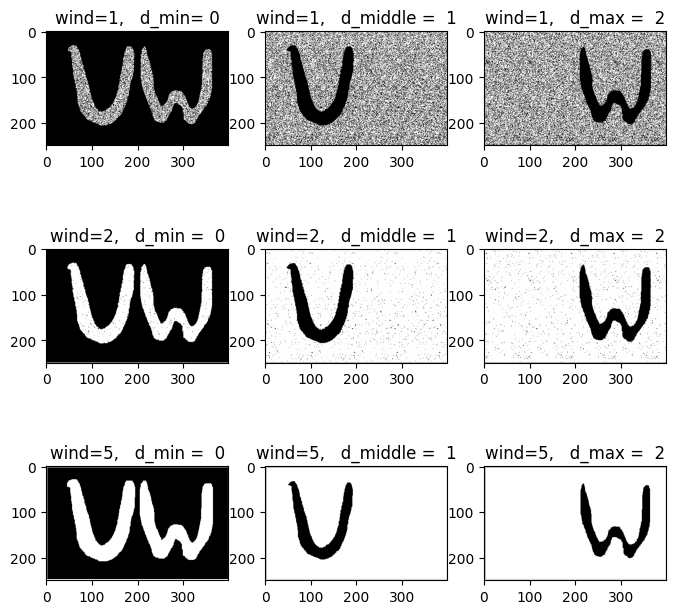

In [11]:
SSD1 = np.zeros(np.shape(SD))
SSD2 = np.zeros(np.shape(SD))
SSD5 = np.zeros(np.shape(SD))

for Delta in range(1+d_max-d_min):
    SSD1[Delta] = windSum(SD[Delta],1)
    SSD2[Delta] = windSum(SD[Delta],2)
    SSD5[Delta] = windSum(SD[Delta],5)
    
d_middle = round((d_min+d_max)/2)
        
fig = plt.figure(figsize = (8, 8))
plt.subplot(331)
plt.title('wind=1,   d_min={:>2d}'.format(d_min))
plt.imshow(1+SSD1[0], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(332) 
plt.title('wind=1,   d_middle = {:>2d}'.format(d_middle))
plt.imshow(1+SSD1[d_middle-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(333)
plt.title('wind=1,   d_max = {:>2d}'.format(d_max))
plt.imshow(1+SSD1[d_max-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(334)
plt.title('wind=2,   d_min = {:>2d}'.format(d_min))
plt.imshow(1+SSD2[0], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(335) 
plt.title('wind=2,   d_middle = {:>2d}'.format(d_middle))
plt.imshow(1+SSD2[d_middle-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(336)
plt.title('wind=2,   d_max = {:>2d}'.format(d_max))
plt.imshow(1+SSD2[d_max-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(337)
plt.title('wind=5,   d_min = {:>2d}'.format(d_min))
plt.imshow(1+SSD5[0], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(338) 
plt.title('wind=5,   d_middle = {:>2d}'.format(d_middle))
plt.imshow(1+SSD5[d_middle-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(339)
plt.title('wind=5,   d_max = {:>2d}'.format(d_max))
plt.imshow(1+SSD5[d_max-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))

### Function computes "disparity map" from SSD arrays (as above) for each disparity in the range specified by integers $d_{min}$, $d_{max}$. It returns a disparity map (image). At each pixel, disparity map image has disparity value corresponding to the minimum SSD at this pixel. For pixels at the margins, the disparity map is set to zero.

In [ ]:

def SSDtoDmap(SSD_array, d_minimum, d_maximum):
    dMap = np.full(np.shape(SSD_array[0]), 0)
    min_SSD = np.full(np.shape(dMap), INFTY)
    for i, d in enumerate(range(d_minimum, d_maximum + 1)):
        dMap = np.where(SSD_array[i] < min_SSD, d, dMap)
        min_SSD = np.minimum(min_SSD, SSD_array[i])
    return dMap

### Compute and show disparity map

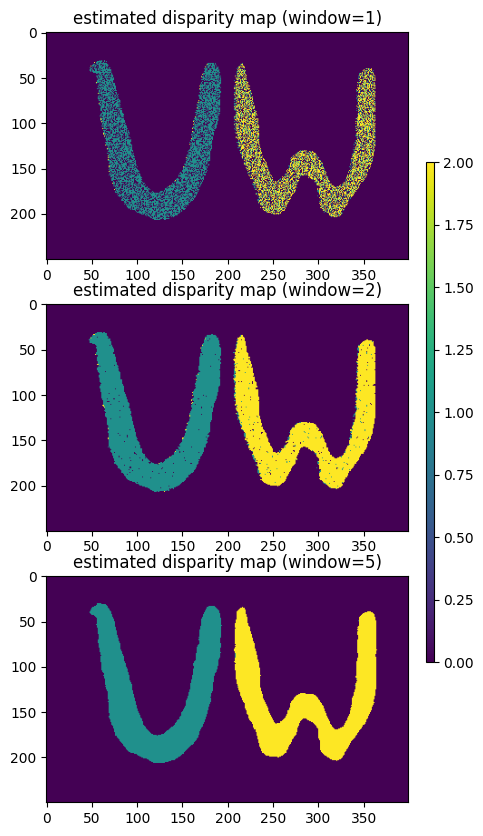

In [13]:
dMap1 = SSDtoDmap(SSD1,d_min,d_max)
dMap2 = SSDtoDmap(SSD2,d_min,d_max)
dMap5 = SSDtoDmap(SSD5,d_min,d_max)

fig = plt.figure(figsize = (5, 10))
plt.subplot(311)
plt.title("estimated disparity map (window=1)")
plt.imshow(dMap1, vmin = 0, vmax = d_max)
plt.subplot(312)
plt.title("estimated disparity map (window=2)")
plt.imshow(dMap2, vmin = 0, vmax = d_max)
plt.subplot(313)
plt.title("estimated disparity map (window=5)")
plt.imshow(dMap5, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.25, 0.015, 0.5]))

## Test code on a real stereo pair with ground truth (Tsukuba)

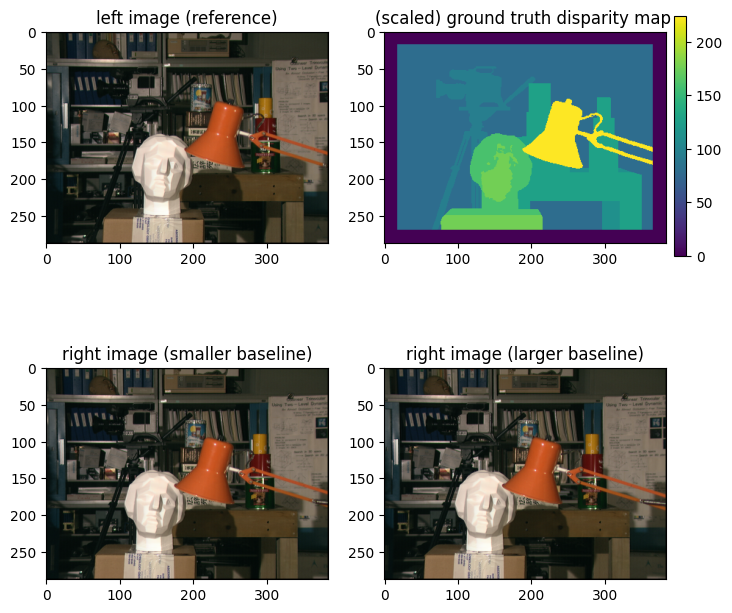

In [14]:
# images/tsukuba subdirectory contains (a subset of) "Tsukuba" stereo images that are probably 
# the oldest stereo data with dense ground-truth produced at the University of Tsukuba in 2001. 
# The full Tsukuba dataset and many other stereo images with ground-truth disparity maps can be
# downloaded from well-known Middlebury repository  http://vision.middlebury.edu/stereo/
im_left = image.imread("images/stereo_pairs/tsukuba/scene1.row3.col3.ppm")
im_gt = image.imread("images/stereo_pairs/tsukuba/truedisp.row3.col3.pgm")
im_right = image.imread("images/stereo_pairs/tsukuba/scene1.row3.col4.ppm")
im_right2 = image.imread("images/stereo_pairs/tsukuba/scene1.row3.col5.ppm")

fig = plt.figure(figsize = (8, 8))
plt.subplot(221)
plt.title("left image (reference)")
plt.imshow(im_left)
plt.subplot(222) 
plt.title("(scaled) ground truth disparity map ")
plt.imshow(im_gt)
plt.colorbar(cax=plt.axes([0.91, 0.557, 0.015, 0.3]))
plt.subplot(223)
plt.title("right image (smaller baseline)")
plt.imshow(im_right)
plt.subplot(224)
plt.title("right image (larger baseline)")
plt.imshow(im_right2)

### Note that the integer-valued ground truth image above represents scaled disparity values for the pixels in the reference (left) mage. The scale w.r.t. the smaller baseline right image ($im\_right$) is 16 and for the larger baseline image ($im\_right2$) is 8. Below, we use the smaller-baseline right image ($im\_right$). 

### Using ground truth disparity map, we estimate the range of disparity values between pixels in the left image ($im\_left$) and the right image ($im\_right$) .

In [ ]:

d_min = np.min(im_gt[im_gt > 0]) // 16 # change me
d_max = np.max(im_gt[im_gt > 0]) // 16 # change me
print("min: ", d_min, "max: ", d_max)

min:  5 max:  14


### Compute squared differences using $SD\_array$ function and visualize the results using logarithmic scale. Note that linear scale would make it hard to see smaller squared differences since there are many very large ones.

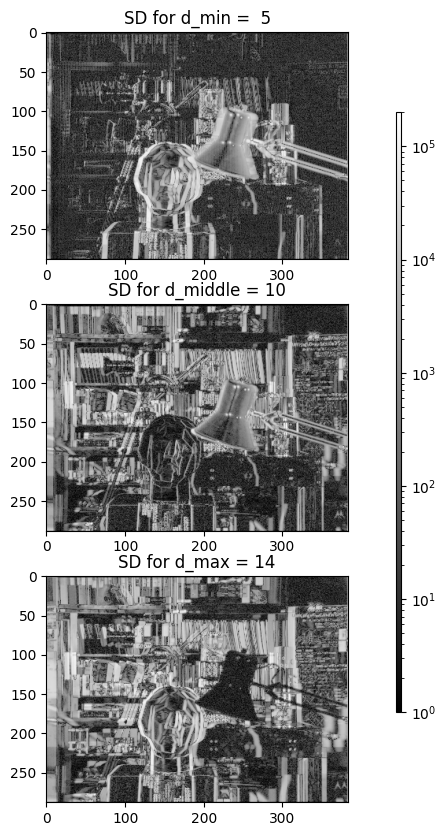

In [16]:
SD = SD_array(im_left, im_right, d_min, d_max)    
    
fig = plt.figure(figsize = (5, 10))
plt.subplot(311)
plt.title('SD for d_min = {:>2d}'.format(d_min))
plt.imshow(im_left)
plt.imshow(1+SD[0], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(312) 
d_middle = round((d_min+d_max)/2)
plt.title('SD for d_middle = {:>2d}'.format(d_middle))
plt.imshow(1+SD[d_middle-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(313)
plt.title('SD for d_max = {:>2d}'.format(d_max))
plt.imshow(1+SD[d_max-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.colorbar(cax=plt.axes([0.91, 0.2, 0.01, 0.6]))

For $d_{min}$, objects in the background (i.e. bookshelf, wall) have the smallest SSD. For $d_{middle}$, objects in the middle ground (i.e. desk, head statue) have the smallest SSD. For $d_{max}$, objects in the foreground (i.e. lamp) have the smallest SSD. This aligns with our understanding that objects further away from the camera will have a smaller disparity between the left and right camera views. Objects closer to the camera are expected to have much larger disparities. For $d_{min}$, objects in the foreground have more unique details and since they naturally have a larger disparities they are not gonna match for small disparities. For $d_{max}$, objects in background may still match since their details are less unique (they repeat a lot).

### Function $Dmap\_Windows$ returns disparith map from a given stereo pair (left and right image), specified disparity range, and window size.

In [17]:
def Dmap_Windows(imageL, imageR, d_minimum, d_maximum, window_width):
    SD = SD_array(imageL, imageR, d_minimum, d_maximum)
    windows = np.zeros(SD.shape)
    for i in range(d_maximum + 1 - d_minimum):
        windows[i] = windSum(SD[i], window_width)
    result = SSDtoDmap(windows, d_minimum, d_maximum)
    return result

### Compute and show disparity maps for Tsukuba using small and large windows.

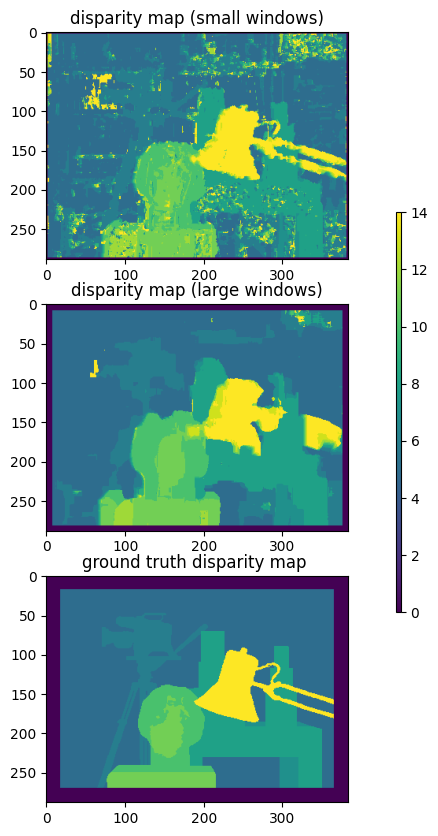

In [18]:
dispMap_small = Dmap_Windows(im_left, im_right, d_min, d_max, 4)
dispMap_large = Dmap_Windows(im_left, im_right, d_min, d_max, 15)

fig = plt.figure(figsize = (5, 10))
plt.subplot(311)
plt.title("disparity map (small windows)")
plt.imshow(dispMap_small, vmin = 0, vmax = d_max)
plt.subplot(312)
plt.title("disparity map (large windows)")
plt.imshow(dispMap_large, vmin = 0, vmax = d_max)
plt.subplot(313) 
plt.title("ground truth disparity map ")
plt.imshow(im_gt/16, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))

# Part II: Scan-line stereo   

We apply the $Viterbi$ approach to Tsukuba example. For the photo-consistency term of the loss function (objective function) we use the previously implemented $SD\_array$ $$D_p(d) = |I_p-I_{p+d}|^2 \;\;\;\;\;\longleftarrow\;\;\;\; SD\_array[d][p] $$ that for every pixel $p$ defines the cost for every possible disparity value $d\in\{d_{min},...,d_{max}\}$. The regularization term is $$V_{pq}(d_p,d_q) = w|d_p-d_q|$$ where you can tune the value of "hyper-parameter" $w$ empirically (start from $w\approx 0$). 

In [53]:
def viterbi(imageL, imageR, d_minimum, d_maximum, w):
    
    SD = SD_array(imageL, imageR, d_minimum, d_maximum)
    return viterbi_for_SD(SD, d_minimum, d_maximum, w)

def viterbi_for_SD(SD, d_minimum, d_maximum, w):
    d, m, n = SD.shape # d = d_maximum - d_minimum + 1, m and n are dimensions of image
    best_disparity = np.zeros((m,n)) # best disparity for each pixel in the image
    min_cost = np.zeros_like(SD) # accumulated cost for the current row column with that disparity
    min_path = np.zeros_like(SD) # best accumulated path thus far for the given disparity
    regularization = w * np.abs(np.arange(d)[:, None] - np.arange(d)[None, :]) # regularization term, (i,j) entry is |i - j|
    
    # iterate over each column
    for i in range(1, n):
        if i == 0: # for base case, first column just add the photo_consistency term
            min_cost[:, :, 0] = SD[:, : , 0] 
        else:
            min_cost_newaxis = min_cost[:, :, i-1][None, :, :] # add new axis at start: d x m -> 1 x d x m
            regularization_newaxis = regularization[:,:,None] # add new axis at end: d x d -> d x d x 1
            SD_newaxis = SD[:, :, i][:, None, :] # add new axis in the middle: d x m -> d x 1 x m
            curr_cost = min_cost_newaxis + SD_newaxis + regularization_newaxis # compute the cost for each disparity along each row
            
            # Using the new axes allow us to broadcast the arrays together into d x d x m 
            # (first d for current disparity and second d for previous disparity)
            # for each the current disparity, choose the past disparity that minimizes the cost
            min_cost[:,:,i] = np.min(curr_cost, axis=1) # use cost to find the previous node in the optimal path
            min_path[:,:,i] = np.argmin(curr_cost, axis=1) # store disparity that minimizes cost
                
    
    # get final disparity that minimizes cost
    best_cost = np.argmin(min_cost[:, :, -1], axis=0) 
    best_disparity = np.zeros_like(SD[0])

    # backtrack to determine optimal path
    for i in reversed(range(n - 1)):
        row_argmin = min_path[:, :, i].T # get optimal disparities for the given column
        best_disparity[:, i] = best_cost # store on the path
        best_cost = row_argmin[np.arange(m), best_cost].T.astype(int) # get the next optimal disparity

    return best_disparity + d_minimum # go from relative disparity to actual disparity

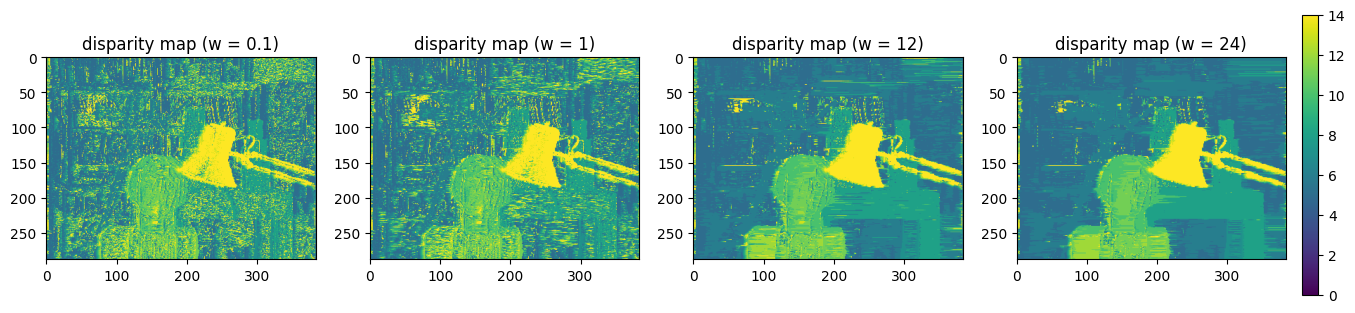

In [61]:
v1 = viterbi(im_left, im_right, d_min, d_max, 0.1)
v2 = viterbi(im_left, im_right, d_min, d_max, 1)
v3 = viterbi(im_left, im_right, d_min, d_max, 12)
v4 = viterbi(im_left, im_right, d_min, d_max, 24)

fig = plt.figure(figsize = (16, 7))
plt.subplot(141)
plt.title("disparity map (w = 0.1)")
plt.imshow(v1, vmin = 0, vmax = d_max)
plt.subplot(142)
plt.title("disparity map (w = 1)")
plt.imshow(v2, vmin = 0, vmax = d_max)
plt.subplot(143) 
plt.title("disparity map (w = 12)")
plt.imshow(v3, vmin = 0, vmax = d_max)
plt.subplot(144) 
plt.title("disparity map (w = 24)")
plt.imshow(v4, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))

### We test the case where the photoconsistency term $D_p(d)$ is computed by averaging SD in some small window of size $h$. That is, for each disparity $d$ we replace 2D array $SD\_array(d)$ by $$SD\_array(d)   \;\;\;\;\;\longleftarrow\;\;\;\;  windSum(SD(d),h).$$ We compare the results for different window sizes $h\in\{1,3,5\}$. 

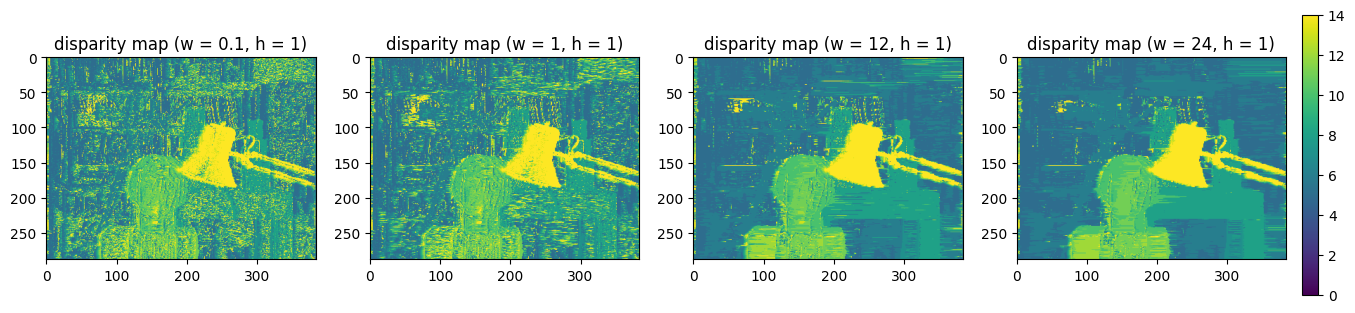

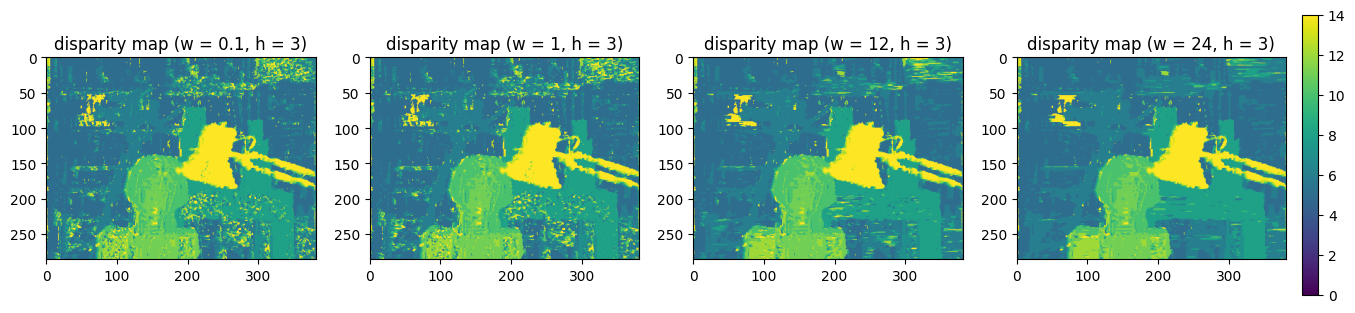

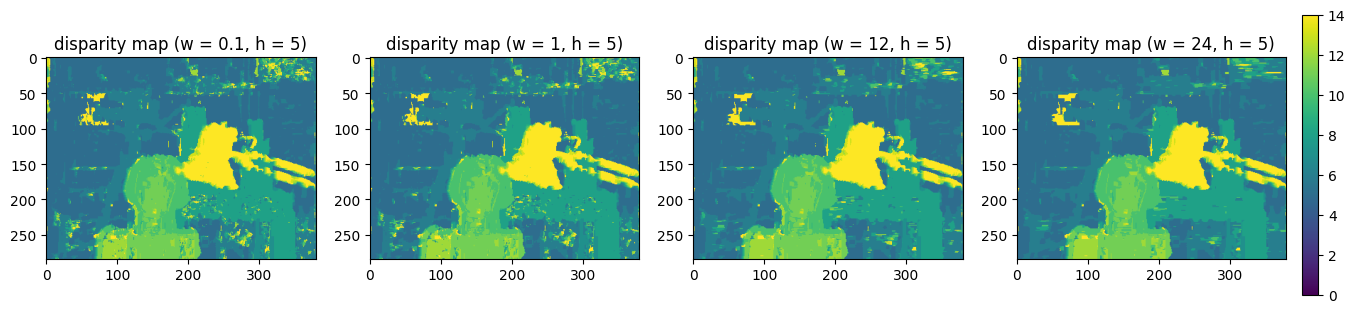

In [62]:
def viterbi_window(imageL, imageR, d_minimum, d_maximum, w, h):
    SD = SD_array(imageL, imageR, d_minimum, d_maximum) # compute square diff for images
    SD_window = []
    for delta in range(d_maximum - d_minimum + 1):
        window_SD = windSum(SD[delta], h) # use windSum to sum over window of size h

        # remove padding i.e. INFTY entries
        m, n = window_SD.shape
        left = h - 1 - (h // 2)
        right = n - (h // 2)
        top = h - 1 - (h // 2)
        bottom = m - (h // 2)
        SD_window.append(window_SD[top:bottom, left:right])
    return viterbi_for_SD(np.array(SD_window), d_minimum, d_maximum, w) # run the rest of Viterbi on the new SD array

for h in [1, 3, 5]:
    v1 = viterbi_window(im_left, im_right, d_min, d_max, 0.1, h)
    v2 = viterbi_window(im_left, im_right, d_min, d_max, 1, h)
    v3 = viterbi_window(im_left, im_right, d_min, d_max, 12, h)
    v4 = viterbi_window(im_left, im_right, d_min, d_max, 24, h)

    fig = plt.figure(figsize = (16, 7))
    plt.subplot(141)
    plt.title(f"disparity map (w = 0.1, h = {h})")
    plt.imshow(v1, vmin = 0, vmax = d_max)
    plt.subplot(142)
    plt.title(f"disparity map (w = 1, h = {h})")
    plt.imshow(v2, vmin = 0, vmax = d_max)
    plt.subplot(143) 
    plt.title(f"disparity map (w = 12, h = {h})")
    plt.imshow(v3, vmin = 0, vmax = d_max)
    plt.subplot(144) 
    plt.title(f"disparity map (w = 24, h = {h})")
    plt.imshow(v4, vmin = 0, vmax = d_max)
    plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))